<h3> Importing Libraries </h3>

In [183]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt

<h3> Loading +/- Data </h3>

In [184]:
# Load positive and negative data sets as dataframe
positive_data = pd.read_csv('../deep_annotator_data/positive_sample.txt', header=None, nrows=1000)
positive_data.columns = ["Gene"]
negative_data = pd.read_csv('../deep_annotator_data/negative_sample.txt', header=None, nrows=1000)
negative_data.columns = ["Gene"]
data_ = pd.concat([positive_data, negative_data])

<h3> Hyper Parameters </h3>

In [220]:
batch_size = 1
embedding_size = 5
window = 1
fc_layer_size = (len(positive_data.Gene[0])-(window-1))*embedding_size
hidden_layer_size = 100
num_layers = 2
epochs = 100
lr = 0.01

<h3> Generate word IDs <h3>

In [221]:
strings = set()
def allLexicographicRecur (string, data, last, index): 
    length = len(string)
    for i in range(length): 
        data[index] = string[i] 
        if index==last:
            res = ''.join(data)
            strings.add(res)
        else: 
            allLexicographicRecur(string, data, last, index+1) 
def allLexicographic(string, n): 
    length = len(string)
    data = [""] * (length+1)
    string = sorted(string) 
    allLexicographicRecur(string, data, window-1, 0)
string = "01234"
allLexicographic(string, window)
strings = sorted(strings)
vocabulary = {}
for val, i in enumerate(strings):
    vocabulary[i] = val
print(vocabulary)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}


<h3> Generate Word Embeddings </h3>

In [222]:
# embeds = nn.Embedding(len(vocabulary), 5)
# embeddings = {}
# def generate_embeddings():
#     for word in vocabulary:
#         embeddings[word] = embeds(torch.tensor(vocabulary[word], dtype=torch.long)).type(torch.LongTensor)

# generate_embeddings()
# print(embeddings['0'].type())

In [223]:
def generate_samples(data_sample):
    list_of_tensors = []
    for data in data_sample.itertuples():
        for i in range(len(data.Gene) - window + 1):
            if i == 0:
                first_tensor = embeddings[data.Gene[i:i+window]]
            else:
                first_tensor = torch.cat((first_tensor, embeddings[data.Gene[i:i+window]]), 0)
        list_of_tensors.append(first_tensor)
    trainpositives = torch.stack(list_of_tensors)
    return trainpositives

# positives = generate_samples(positive_data)
# print(positives.type())
# negatives = generate_samples(negative_data)
# print(negatives.type())
# data_ = torch.cat([positives, negatives], dim=0)
# print(data_.type())

negative_labels = torch.zeros(negatives.shape[0], 1)
positive_labels = torch.ones(positives.shape[0], 1)
labels_ = torch.cat([positive_labels, negative_labels], dim=0)

<h3> Neural Network Layer Implementation </h3>

In [224]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embeds = nn.Embedding(len(vocabulary), 5)
        self.lstm = nn.LSTM(fc_layer_size, fc_layer_size, num_layers)
        self.fc1 = nn.Linear(fc_layer_size, hidden_layer_size)
        self.relu1 = nn.Sigmoid()
        self.out = nn.Linear(hidden_layer_size, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        h = autograd.Variable(torch.randn(num_layers, batch_size, fc_layer_size))
        c = autograd.Variable(torch.randn(num_layers, batch_size, fc_layer_size))
        z = self.embeds(x).view((1,-1))
#         print(z)
#         out_lstm, hn = self.lstm(z, (h, c))
        a1 = self.fc1(z)
        h1 = self.relu1(a1)
        a3 = self.out(h1)
        y = self.out_act(a3)
        return y
net = Net()

<h4> Optimizer step and loss calculation </h4>

In [225]:
opt = optim.SGD(net.parameters(), lr, momentum=0.0)
criterion = nn.BCELoss()

<h4> Train method </h4>

In [226]:
def train_epoch(model, opt, criterion, batch_size=1):
    model.train()
    losses = []
    c = 0
    for data in data_.itertuples():
        
        data_batch = torch.tensor([vocabulary[data.Gene[i:i+window]] for i in range(0, len(data.Gene) - window + 1)], dtype=torch.long)
        labels_batch = labels_[c]
        c+=1
        data_batch = autograd.Variable(data_batch)
        labels_batch = autograd.Variable(labels_batch)

        opt.zero_grad()
        
        # Extend the side of the data_batch to adhere to LSTM layer implementation
        # data_batch.unsqueeze_(0)
        # data_batch = data_batch.expand(1, batch_size, fc_layer_size)
        labels_hat = net(data_batch)
        
        # Compute the binary Cross Entropy Loss
        loss = criterion(labels_hat, labels_batch)

        loss.backward()

        opt.step()        
        losses.append(loss.data.numpy())
    loss = sum(losses)/len(losses)
    return loss

Average Loss at epoch, 0 : 0.046304432549281044
Average Loss at epoch, 2 : 0.06557600355957402
Average Loss at epoch, 4 : 0.04237065669041476
Average Loss at epoch, 6 : 0.028904671456970392
Average Loss at epoch, 8 : 0.024026454277598534
Average Loss at epoch, 10 : 0.020993312279793827
Average Loss at epoch, 12 : 0.018478478838262164
Average Loss at epoch, 14 : 0.01660286415192178
Average Loss at epoch, 16 : 0.01520521594021602
Average Loss at epoch, 18 : 0.014141474395715534
Average Loss at epoch, 20 : 0.013318969024315145
Average Loss at epoch, 22 : 0.012608414226350263
Average Loss at epoch, 24 : 0.01189078192320261
Average Loss at epoch, 26 : 0.011199211213542235
Average Loss at epoch, 28 : 0.010625393995910642
Average Loss at epoch, 30 : 0.010094715364414562
Average Loss at epoch, 32 : 0.009591535569974831
Average Loss at epoch, 34 : 0.009101976967259319
Average Loss at epoch, 36 : 0.00862817637571272
Average Loss at epoch, 38 : 0.00822585036047154
Average Loss at epoch, 40 : 0.00

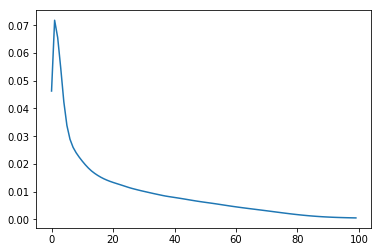

In [227]:
def train():
    losses = []
    for e in range(epochs):
        loss = train_epoch(net, opt, criterion, batch_size)
        losses.append(loss)
        if e % 2 == 0:
            print('Average Loss at epoch,',e,':',loss)
    torch.save(net.state_dict(), 'fc_with_lstm.pt')
    plt.plot(losses)
train()

<h3> Test Data Prediction </h3>

<h4> Load the Model and test data </h4>

In [228]:
#load model
model = Net()
model.load_state_dict(torch.load('fc_with_lstm.pt'))
model.eval()
print(model)
# load data
positive_test_data = pd.read_fwf('positive_sample_test.txt', header = None)
positive_test_data.columns = ["Gene"]
negative_test_data = pd.read_fwf('negative_sample_test.txt', header = None)
negative_test_data.columns = ["Gene"]

Net(
  (embeds): Embedding(5, 5)
  (lstm): LSTM(505, 505, num_layers=2)
  (fc1): Linear(in_features=505, out_features=100, bias=True)
  (relu1): Sigmoid()
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


<h4> Test and Label Embeddings </h4>

In [230]:
data_test = pd.concat([positive_test_data, negative_test_data])

<h4> Generate output labels for test predictions </h4>

In [231]:
def test_prediction_model(data_test, labels_predicted):
    correct, wrong = 0, 0
    for data in data_test.itertuples():
        data_testing = torch.tensor([vocabulary[data.Gene[i:i+window]] for i in range(0, len(data.Gene) - window + 1)], dtype=torch.long)
        # data_test_.unsqueeze_(0)
        # data_testing = data_test_.expand(1, batch_size, fc_layer_size)
        labels_hat = net(data_testing)
        labels_predicted.append(labels_hat[0])
    for i in range(len(labels_predicted)//2 + 1):
        if labels_predicted[i] > 0.5:
            correct += 1
        else:
            wrong += 1
    for i in range(101, len(labels_predicted)):
        if labels_predicted[i] > 0.5:
            wrong += 1
        else:
            correct += 1
    print(correct,wrong)
labels_predicted = []
test_prediction_model(data_test, labels_predicted)

179 21


<h4> Accuracy for Test predictions </h4>

In [60]:
def test_prediction_accuracy(labels):
    correct, wrong = 0, 0
    labels_hat = labels
    for i in range(len(labels_hat)//2 + 1):
        if labels_hat[i] > 0.5:
            correct += 1
        else:
            wrong += 1
    for i in range(101, len(labels_hat)):
        if labels_hat[i] > 0.5:
            wrong += 1
        else:
            correct += 1
    return (correct,wrong)

In [198]:
batch_size = 100
embedding_size = 5
fc_layer_size = (len(positive_data.Gene[0])-(window-1))*embedding_size
hidden_layer_size = 100
num_layers = 2
epochs = 500
lr = 0.02
train()
# labels = []
# test_prediction_model(data_test, labels)
# results = test_prediction_accuracy(labels)
# print("Correct Predictions:", results[0])
# print("Wrong Predictions:", results[1])